<a href="https://colab.research.google.com/github/kharchoufiabdelkarim/abstractivesummary/blob/main/bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from bs4 import BeautifulSoup
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Embedding, Dense, TimeDistributed, Concatenate, Attention
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
data = pd.read_csv('/content/spellgenerpara.csv')
data.rename(columns={'document': 'text', 
                           'summary': 'summary'}, inplace=True)

In [ ]:
_MAX_SUMMARY_LEN = 20
_MAX_TEXT_LEN    = 120
# Declaring the important variables here, which will be used later down the notebook

_NROWS           =   999
_TEXT_PADDING    =   'post'
_EMBEDDING_DIM   =   500
_ENCODER_DIM     =   300
_DECODER_DIM     =   600
_BATCH_SIZE      =   16
_EPOCHS          =   30

In [ ]:

def prepare(dataset):
  global _MAX_SUMMARY_LEN, _MAX_TEXT_LEN
  newtext    =  []
  newsummary =  []
  
  for i in range(len(dataset['text'])):
    if len(dataset['text'][i].split()) <= _MAX_TEXT_LEN and len(dataset['summary'][i].split()) <= _MAX_SUMMARY_LEN:
      newtext.append(dataset['text'][i])
      newsummary.append(dataset['summary'][i])

  dataset = pd.DataFrame({'text'    : newtext,
                          'summary' : newsummary})
  dataset['summary'] = dataset['summary'].apply(lambda row : 'stok ' + row + ' etok')
  dataset.reset_index(drop=True, inplace=True)
  return dataset

In [ ]:
df = prepare(data)

In [ ]:

df.head()

,text,summary
0,who and where to get cetirizine d i need want...,stok who manufactures cetirizine etok
1,who makes bromocriptine i am wondering what co...,stok who manufactures bromocriptine etok
2,nulytely hello can you tell me where do i ord...,stok who makes nulytely and where can i buy it...
3,williams syndrome i would like to have my daug...,stok where can i get genetic testing for willi...
4,clinicaltrials gov question general informatio...,stok where can i get genetic testing for multi...


In [ ]:
df['text'][1]

'who makes bromocriptine i am wondering what company makes the drug bromocriptine i need it for a mass i have on my pituitary gland and the cost just keeps raising i cannot ever buy a full prescription because of the price and i was told if i get a hold of the maker of the drug sometimes they offer coupons or something to help me afford the medicine if i buy pills in which i have to take times a day it costs me and that is how i have to buy them thanks '

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.2, random_state=42)

In [ ]:
# preparing 'text' for model training and validation
tok_x  = Tokenizer()
tok_x.fit_on_texts(list(x_tr))
x_tr    =  pad_sequences(tok_x.texts_to_sequences(x_tr),  maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
x_val   =  pad_sequences(tok_x.texts_to_sequences(x_val), maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
vocab_x =  len(tok_x.word_counts) + 1

In [ ]:
vocab_x

4367

In [ ]:
# preparing 'summary' for model training and validation
tok_y  = Tokenizer()
tok_y.fit_on_texts(list(y_tr))
y_tr    =  pad_sequences(tok_y.texts_to_sequences(y_tr),  maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
y_val   =  pad_sequences(tok_y.texts_to_sequences(y_val), maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
vocab_y =  len(tok_y.word_counts) + 1

In [ ]:
vocab_y

1713

In [ ]:
tok_y.word_counts['stok'], len(y_tr)

(577, 577)

In [ ]:
index_to_word_text    =  tok_x.index_word
index_to_word_summary =  tok_y.index_word
word_to_index_summary =  tok_y.word_index

In [ ]:
# Encoder
encoder_input  =  Input(shape=(_MAX_TEXT_LEN,), name='Encoder_input')
encoder_embed  =  Embedding(vocab_x, _EMBEDDING_DIM, trainable=True, name='Encoder_embedding')(encoder_input)
encoder        =  Bidirectional(LSTM(_ENCODER_DIM, 
                                     return_sequences=True,
                                     return_state=True,
                                     dropout=0.4, recurrent_dropout=0.4), name='Encoder_layer')
encoder_output, forward_h, forward_c, backward_h, backward_c = encoder(encoder_embed)
state_h        =  Concatenate()([forward_h, backward_h])
state_c        =  Concatenate()([forward_c, backward_c])

# Decoder
decoder_input        =  Input(shape=(None,), name='Decoder_input')
decoder_embed_layer  =  Embedding(vocab_y, _EMBEDDING_DIM, trainable=True, name='Decoder_embedding')
decoder_embed        =  decoder_embed_layer(decoder_input)
decoder              =  LSTM(_DECODER_DIM,
                             return_sequences=True,
                             return_state=True,
                             dropout=0.4, recurrent_dropout=0.3, name='Decoder_layer')
decoder_output, decoder_state_h, decoder_state_c = decoder(decoder_embed,initial_state=[state_h, state_c])

# Attention layer
attention_layer =  Attention(name='Attention_layer')
attention_out   =  attention_layer([decoder_output, encoder_output])

# Concat attention layer's output and decoder's output
concat_layer    =  Concatenate(axis=-1, name='Concat_layer')([decoder_output, attention_out])

# Dense layer
decoder_dense   =  TimeDistributed(Dense(vocab_y, activation='softmax'))
decoder_output  =  decoder_dense(concat_layer)

# Model 
model           =  Model([encoder_input, decoder_input], decoder_output, name='Model')

model.summary()

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_input (InputLayer)     [(None, 120)]        0           []                               
                                                                                                  
 Encoder_embedding (Embedding)  (None, 120, 500)     1763500     ['Encoder_input[0][0]']          
                                                                                                  
 Decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 Encoder_layer (Bidirectional)  [(None, 120, 600),   1922400     ['Encoder_embedding[0][0]']      
                                 (None, 300),                                                 

In [ ]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

stopearly =  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
X         =  [x_tr,y_tr[:,:-1]]
y         =  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:]
VAL_X     =  [x_val,y_val[:,:-1]]
VAL_y     =  y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]
history   =  model.fit(X, y, epochs=30, callbacks=[stopearly], batch_size=_BATCH_SIZE, validation_data=(VAL_X, VAL_y))

Epoch 1/20
37/37 [==============================] - 66s 2s/step - loss: 1.6303 - val_loss: 0.3885
Epoch 2/20
37/37 [==============================] - 53s 1s/step - loss: 0.4731 - val_loss: 0.3500
Epoch 3/20
37/37 [==============================] - 53s 1s/step - loss: 0.4392 - val_loss: 0.3340
Epoch 4/20
37/37 [==============================] - 53s 1s/step - loss: 0.4184 - val_loss: 0.3298
Epoch 5/20
37/37 [==============================] - 53s 1s/step - loss: 0.4035 - val_loss: 0.3163
Epoch 6/20
37/37 [==============================] - 53s 1s/step - loss: 0.3862 - val_loss: 0.3145
Epoch 7/20
37/37 [==============================] - 54s 1s/step - loss: 0.3693 - val_loss: 0.3024
Epoch 8/20
37/37 [==============================] - 53s 1s/step - loss: 0.3489 - val_loss: 0.2913
Epoch 9/20
37/37 [==============================] - 53s 1s/step - loss: 0.3331 - val_loss: 0.2881
Epoch 10/20
37/37 [==============================] - 53s 1s/step - loss: 0.3126 - val_loss: 0.2847
Epoch 11/20
37/37 [

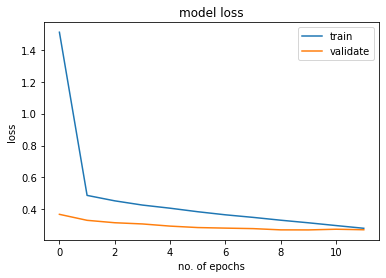

In [ ]:
# For loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('no. of epochs')
plt.ylabel('loss')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [ ]:
_MODEL_NAME = 'model_3'
model.save('/content/drive/My Drive/ML Project/model3.h5')

In [ ]:
encoder_model = Model(inputs  = encoder_input,
                outputs = [encoder_output, state_h, state_c])

# For storing decoder's previous states which will act as our encoder here
decoder_previous_state_h = Input(shape=(_DECODER_DIM,))
decoder_previous_state_c = Input(shape=(_DECODER_DIM,))
decoder_previous_output  = Input(shape=(_MAX_TEXT_LEN, _DECODER_DIM))

# This new decoder will take the 'previous decoder' i.e, our encoder's output
decoder_embed_new = decoder_embed_layer(decoder_input)
decoder_output_new, state_h_new, state_c_new = decoder(decoder_embed_new,
                                                       initial_state = [decoder_previous_state_h, decoder_previous_state_c])

# Attention layer & concat layer for the new decoder and encoder
attention_out_new    =  attention_layer([decoder_output_new, decoder_previous_output])
concat_layer_final   =  Concatenate(axis=-1)([decoder_output_new, attention_out_new])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_output_final =  decoder_dense(concat_layer_final)

# Final decoder model
decoder_model = Model(
    [decoder_input] + [decoder_previous_output, decoder_previous_state_h, decoder_previous_state_c],
    [decoder_output_final] + [state_h_new, state_c_new])

In [ ]:
# Summarizes an input sequence to the final sequence by making the encoder-decoder model 
# predict 1 word at a time

def summarizer(input_seq):
    encoder_out, encoder_h, encoder_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = word_to_index_summary['stok']
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [encoder_out, encoder_h, encoder_c])
        # Greedy decoder
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = index_to_word_summary[sampled_token_index]
        
        if sampled_token != 'etok':
            decoded_sentence += sampled_token + ' '

        if sampled_token == 'etok' or len(decoded_sentence.split()) >= (_MAX_SUMMARY_LEN-1):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        encoder_h, encoder_c = h, c

    return decoded_sentence

In [ ]:
def sequence_to_summary(input_seq):
    s = ''
    for i in input_seq:
        if i != 0 and i != word_to_index_summary['stok'] and i != word_to_index_summary['etok']:
            s += index_to_word_summary[i] + ' '
    return s

def sequence_to_text(input_seq):
    s = ''
    for i in input_seq:
        if i != 0:
            s += index_to_word_text[i] + ' '
    return s

In [ ]:
for i in range(5):
    print("Review:",sequence_to_text(x_tr[i]))
    print("Original summary:",sequence_to_summary(y_tr[i]))
    print("Predicted summary:",summarizer(x_tr[i].reshape(1,_MAX_TEXT_LEN)))
    print("\n")

Review: nail problem my son is in problem of deals so what i do which medicine is better what is the name of my son i nail problem what medicine is better for nail problems my son has a nail problem and i don i know which medicine is better 
Original summary: which medicine is better for a nail problem 
Predicted summary: what are the treatments for dry skin 


Review: trying to loss before july i am trying to loss pounds before july the problem is i work hours a day don i have time to do anything else is there a debt pills or shake that i can use to help me also my problem area is stomach waist butt and hip please help how many pounds am i trying to lose before july what is my problem area i am trying to lose some weight but i don i have time to do anything else and i have a problem with my hip and stomach 
Original summary: where can i find information on weight loss pills 
Predicted summary: what are the treatments for dry skin 


Review: garcia cambodia in the usa and elsewhere ple

In [ ]:
for i in range(5):
    print("Review:",sequence_to_text(x_val[i]))
    print("Original summary:",sequence_to_summary(y_val[i]))
    print("Predicted summary:",summarizer(x_val[i].reshape(1,_MAX_TEXT_LEN)))
    print("\n")

Review: voice hi i am wondering if anyone can help me get my voice back i have als in my throat and i don i want to go out on a disability i want to keep working thank you what is in my throat and i don i want to go out on disability i don i want to go out on a disability and i i wondering if anyone can help me get my voice back 
Original summary: what are the treatments for disorders caused by als 
Predicted summary: what are the treatments for dry skin 


Review: we are planning to develop to cure any kind of paralysis and stroke research how you cure parkinson disease what kind of paralysis are we planning to cure what type of research is to cure parkinson disease we are going to find a cure for paralysis and stroke 
Original summary: what are the treatments for parkinson disease 
Predicted summary: what are the treatments for dry skin 


Review: or my my daily doctor prescribed for type diabetes i my times daily pharmacy refused to of who is right what is maximum daily dos of pharm

In [ ]:
! pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 8.1 MB/s 
     |████████████████████████████████| 106 kB 66.1 MB/s 


In [ ]:
import re
import os
import pickle
import logging
import numpy as np
import pandas as pd
import contractions
from nltk.corpus import stopwords
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)


class Summarizer:

  def __init__(self):
    self.dir_path = '/content/gdrive/My Drive/Colab Notebooks/Summarization/summarization v2'
    self._MAX_TEXT_LEN    =  120
    self._MAX_SUMMARY_LEN =  20
    self._TEXT_PADDING    =  'post'
    self.encoder_model = encoder_model
    self.decoder_model = decoder_model
    self.index_to_word_text, self.index_to_word_summary, self.word_to_index_summary = index_to_word_text, index_to_word_summary, word_to_index_summary
    self.tok_x = tok_x
  
  def summarize(self, sent):
    """wrapper function to test the model"""

    sent = self.cleaner(sent, remove_stopwords=True)
    if len(sent.split()) > self._MAX_TEXT_LEN:
      return "make your sentence length less than {} words".format(self._MAX_TEXT_LEN)

    seq = self.tok_x.texts_to_sequences(sent.split())
    seq = [[item for sublist in seq for item in sublist]]
    seq = pad_sequences(seq, maxlen=self._MAX_TEXT_LEN, padding=self._TEXT_PADDING)
    return self.seq2seq_model(seq.reshape(1, self._MAX_TEXT_LEN))


  def cleaner(self, text, remove_stopwords=True):
    """removes url's, nltk's stopwords and anything which is not an alphabet"""

    stop_words = set(stopwords.words('english'))
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text.lower(), flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = contractions.fix(text, slang=False)
    if remove_stopwords:
      text = ' '.join([word for word in text.split() if word not in stop_words]).strip()
      
    return text
  
  def seq2seq_model(self, input_seq):
    """summarizes the input text given and returns the summarized string"""

    encoder_out, encoder_h, encoder_c = self.encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = self.word_to_index_summary['stok']
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
      output_tokens, h, c = self.decoder_model.predict([target_seq] + [encoder_out, encoder_h, encoder_c])
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_token = self.index_to_word_summary[sampled_token_index]
      
      if sampled_token != 'etok':
        decoded_sentence += sampled_token + ' '
        
      if sampled_token == 'etok' or len(decoded_sentence.split()) >= (self._MAX_SUMMARY_LEN-1):
        stop_condition = True

      target_seq = np.zeros((1,1))
      target_seq[0, 0] = sampled_token_index
      encoder_h, encoder_c = h, c

    return decoded_sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pip install Rouge
from rouge import Rouge

scorer = Rouge()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

# loading our model
model1 = Summarizer()

In [ ]:
def tryit(sent):
  """wrapper function to test the model"""

  sent = cleaner(sent, remove_stopwords=True)
  if len(sent.split()) > _MAX_TEXT_LEN:
    return "make your sentence length less than {} words".format(_MAX_TEXT_LEN)

  seq = tok_x.texts_to_sequences(sent.split())
  seq = [[item for sublist in seq for item in sublist]]
  seq = pad_sequences(seq, maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
  return summarizer(seq.reshape(1,_MAX_TEXT_LEN))

In [ ]:
text = 'We tried the Megna for the first time last night and the food was great, freshly cooked very tasty and well presented. \
The waiters were attentive and service overall was good. The restaurant looked to have been recently decorated. \
Overall a good meal and great value we will certainly be going back.'

real_summary = 'tried megna good food attentive waiters'

In [ ]:
tryit(text)

NameError: ignored

In [ ]:

text1 = text.split('.')
for l in text1:
  if len(l) > 0:
    print('text :', l.strip())
    print('predict:', tryit(l))
    print('\n')

text : We tried the Megna for the first time last night and the food was great, freshly cooked very tasty and well presented


NameError: ignored

In [ ]:
tryit('the food was terribly good')

'what are the treatments for low pain '

In [ ]:
tryit('the food was terrible')

'what are the treatments for low pain '

In [ ]:
tryit('the food was bad at first but finally it turned out to be otherwise')

'what are the treatments for low pain '

In [ ]:
tryit('I love maggi but couldn\'t find any')

'what are the treatments for leg for pain '

In [ ]:

tryit('well the food was not that bad but certainly can be improved')

'what are the treatments for low pain '

In [ ]:
# storing all the rouge scores
rouge_1 = {'f':[], 'p':[], 'r':[]}
rouge_2 = {'f':[], 'p':[], 'r':[]}
rouge_l = {'f':[], 'p':[], 'r':[]}

In [ ]:
for i in range(df.shape[0]):
  text = df['text'][i]
  reference = ' '.join(df['summary'][i].split()[1:-1])
  if len(reference) == 0:
    continue
  hypothesis = model1.summarize(text)
  scores = scorer.get_scores(hypothesis, reference)[0]
  one, two, l = scores['rouge-1'], scores['rouge-2'], scores['rouge-l']
  for p, q in one.items():
    rouge_1[p].append(q)
  for p, q in two.items():
    rouge_2[p].append(q)
  for p, q in l.items():
    rouge_l[p].append(q)

In [ ]:

np.mean(rouge_1['f']), np.mean(rouge_1['p']), np.mean(rouge_1['r'])

In [ ]:
np.mean(rouge_2['f']), np.mean(rouge_2['p']), np.mean(rouge_2['r'])

In [ ]:
np.mean(rouge_l['f']), np.mean(rouge_l['p']), np.mean(rouge_l['r'])

In [ ]:
arr1=list()
arr1.append(["Rouge 1",np.mean(rouge_1['f']), np.mean(rouge_1['p']), np.mean(rouge_1['r'])])
arr1.append(["Rouge 2",np.mean(rouge_2['f']), np.mean(rouge_2['p']), np.mean(rouge_2['r'])])
arr1.append(["Rouge l",np.mean(rouge_l['f']), np.mean(rouge_l['p']), np.mean(rouge_l['r'])])

In [ ]:
Rouge=["Rouge 1","Rouge 2","Rouge l"]

In [ ]:
arr1

In [ ]:
df_final=pd.DataFrame(arr1,columns=["Rouge","f","p","r"],)

In [ ]:
df_final

,Rouge,f,p,r
0,Rouge 1,0.286363,0.318718,0.270756
1,Rouge 2,0.175830,0.192542,0.170154
2,Rouge l,0.282116,0.313592,0.266924
